In [3]:
import glob
import numpy as np 
import time
import math
import random
from scipy import linalg as LA
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import NuSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
import matplotlib.pyplot as plt
from termcolor import colored
from matplotlib import colors
import pickle
from datetime import datetime
import os
from sklearn.svm import LinearSVC
from hmmlearn import hmm
from pprint import pprint 

## Reading cleaned csv files

### User i is data_1$[i]$ in the following

In [4]:
data_1 = [0] * 57
for i in range(len(data_1)):
    fnames = glob.glob('labeled csv Geolife/'+str(i)+'/*.csv')
    data_1[i] = np.array([np.loadtxt(f, delimiter=',')[1:] for f in fnames])
data_1 = np.array(data_1)

In [5]:
fnames = glob.glob('labeled csv Geolife/**/*.csv')
len(fnames)

3572

### Users are stacked together in data_2 below

In [6]:
data_2 = []
fnames = glob.glob('labeled csv Geolife/**/*.csv')
for f in fnames:
    data_2.append(np.loadtxt(f, delimiter=',')[1:])
data_2 = np.array(data_2)

In [7]:
A = np.array([len(data_2[i]) for i in range(len(data_2))])
min(A), max(A)

(3, 40392)

### Removing segments with length less than 1e-10 because of numerical precision

In [8]:
data_3 = [0] * len(data_2)
h = 1e-10
c = 0
for i in range(len(data_2)):
    p1 = data_2[i][:-1]
    p2 = data_2[i][1:]
    L = ((p2[:,:2]-p1[:,:2])*(p2[:,:2]-p1[:,:2])).sum(axis =1)
    I = np.where(L > h)[0]
    J = np.where(L < h)[0]
    if len(J) > 0:
        c += 1
    p1 = p1[I]
    p2 = p2[I]
    if len(I) == 0:
        print(i)
    gamma = np.concatenate((p1, p2[-1].reshape(1,4)), 0) 
    if len(gamma) > 0:
        data_3[i] = gamma
    data_3[i] = np.array(data_3[i])
data_3 = np.array(data_3)
c

3182

In [9]:
A = np.array([len(data_3[i]) for i in range(len(data_3))])
min(A), max(A), np.where(A > 40000)[0]

(2, 40323, array([1380]))

# Partitioning trajectories to less than 20 minutes long

In [10]:
# 24 * 60 * (days_date('1899/12/30 2:50:06') - days_date('1899/12/30 2:20:06')) == 20 min
Time = np.zeros(len(data_3))
for i in range(len(data_3)):
    Time[i] = 24 * 60 * sum(data_3[i][:,2][1:] - data_3[i][:,2][:-1]) # = 20 minutes 
min(Time), max(Time), np.where(Time>2000)

(0.08333337376825511, 2085.283333301777, (array([2940]),))

In [11]:
J = np.where(Time>20)[0]
len(J)

2365

In [12]:
def partition(trajectory):
    trajectories = []
    a = 24 * 60 * sum(trajectory[:,2][1:] - trajectory[:,2][:-1])
    if a <= 20:
        return np.array(trajectory.reshape(1, len(trajectory), 4))
    else: 
        i = 0
        while a > 20:
            j = i + 0
            val = 0
            while val < 20: 
                if i < len(trajectory) - 1:
                    temp = val + 0
                    val += 24 * 60 * (trajectory[:,2][1:][i] - trajectory[:,2][:-1][i])
                    i += 1
                else: 
                    break
            if len(trajectory[j:i-1]) > 0:
                trajectories.append(trajectory[j:i-1])
            a = a - val
        if len(trajectory[i:]) > 0:
            trajectories.append(trajectory[i:])
    return trajectories

In [13]:
# Check to see if partitioning into less than 20 minutes worked correctly
for j in J:
    A = partition(data_3[j])
    B = np.array([24 * 60 * sum(A[i][:,2][1:] - A[i][:,2][:-1]) for i in range(len(A))])
    I = np.where(B > 20)[0]
    if len(I) > 0: 
        print(j)

### data_4 below is the array of trajectories having less than 20 minutes long

In [14]:
data_4 = []
for i in range(len(data_3)):
    A = partition(data_3[i])
    for j in range(len(A)):
        data_4.append(A[j])
data_4 = np.array(data_4)

In [15]:
data_4.shape, data_4[0].shape

((11833,), (360, 4))

In [16]:
I = np.where(np.array([len(data_4[i]) for i in range(len(data_4))]) != 1)[0]
data_4 = data_4[I]
len(data_4)

11751

In [17]:
int1 = np.vectorize(int)
data_5 = []
c = 0
for i in range(len(data_4)):
    if len(set(int1(data_4[i][:,3]))) < 2: 
        data_5.append(data_4[i])
        c += 1
data_5 = np.array(data_5)
c

10039

In [18]:
data_6 = []
d = 0
for i in range(len(data_4)):
    if len(set(int1(data_4[i][:,3]))) == 2: 
        data_6.append(data_4[i])
        d += 1
data_6 = np.array(data_6)
d

1671

In [19]:
# a:b
# a is the number of labels in a trajectory
# b is the number of trajectries with a labels
D = {1:10121, 2:1671, 3:39, 4:2, 5:0}

In [20]:
Modes = ['walk', 'bike', 'bus', 'driving', 'train']

In [21]:
C = []
for j in range(5):
    c = 0
    for i in range(len(data_5)):
        if data_5[i][0][-1] == j:
            c += 1
    C.append(c)
print("number of trajectories of length 1 with label 0, 1, 2, 3, 4:", C)

number of trajectories of length 1 with label 0, 1, 2, 3, 4: [3383, 1650, 1929, 2214, 863]


# Creating trajectories with 3, 4, 5 labels

### Preparing length 2 sentences

In [22]:
data_7 = [0] * len(data_6)
for i in range(len(data_6)):
    I = list(set(data_6[i][:,3]))
    data_7[i] = []
    J1 = np.where(data_6[i][:,3] == I[0])
    J2 = np.where(data_6[i][:,3] == I[1])
    D1 = data_6[i][J1]
    D2 = data_6[i][J2]
    data_7[i].append(D1)
    data_7[i].append(D2)
data_7 = np.array(data_7)
data_7.shape

(1671, 2)

### Creating sentences of length 3, 4, 5 from 10039 length 1 trajectories

In [23]:
data = []

n_1 = 1000 # number of length 1 sentences
n_2 = 1000 # len(data_7)# 1671: number of length 2 sentences
n_3 = 800 # number of length 3 sentences
n_4 = 700 # number of length 4 sentences
n_5 = 1900 # number of length 5 sentences

for i in range(n_1):
    I = np.random.randint(0, 10039, size=1)
    data.append(data_5[I])
    
for i in range(n_2): 
    data.append(data_7[i])

for i in range(n_3):
    I = np.random.randint(0, 10039, size=3)
    data.append(data_5[I])

for i in range(n_4):
    I = np.random.randint(0, 10039, size=4)
    data.append(data_5[I])
    
for i in range(n_5):
    I = np.random.randint(0, 10039, size=5)
    data.append(data_5[I])
    
data = np.array(data)
data.shape

(5400,)

### Length of sentences

In [24]:
print(data[0].shape, data[n_1].shape, data[n_1+n_2].shape, data[n_1+n_2+n_3].shape, 
      data[n_1+n_2+n_3+n_4].shape)

(1,) (2,) (3,) (4,) (5,)


# Functions needed for CMM

### Feature Mappings

$x = (x_1, x_2, \ldots, x_n)$

$y = (y_1, y_2, \ldots, y_n) \in \{0,1,2,3,4\}^n$

If $x_i = [(a_0, b_0, t_0), \ldots, (a_m, b_m, t_m)]$, where $a_j$ is latitude, $b_j$ is longitude and $t_j$ is time, then 
$$\displaystyle \text{length}_i = \frac{1}{m} \sum_{j=1}^m \|(a_j, b_j) - (a_{j-1}, b_{j-1})\|_2,$$
$$\text{velocity}_i = \frac{1}{m} \sum_{j=1}^m \frac{\|(a_j, b_j) - (a_{j-1}, b_{j-1})\|_2}{t_j},$$
$$\text{acceleration}_i = \frac{1}{m} \sum_{j=1}^m \frac{\|(a_j, b_j) - (a_{j-1}, b_{j-1})\|_2}{t_j^2}.$$

#Notice: I have divded the acceleration by 1e10 for all data. 

### $\phi_1(x, y) = (\text{length}_i, \text{velocity}_i, \text{acceleration}_i, y_i)_{i=1}^n \in \mathbb{R}^{4n}$

### $\phi_2(x, y) = (\text{start point}_i, \text{end point}_i, \text{length}_i, \text{velocity}_i, \text{acceleration}_i, y_i)_{i=1}^n \in \mathbb{R}^{8n}$

### Feature Mapping $\phi_1$

In [23]:
def featureMapping1(data):
    Data = [0] * len(data)
    for i in range(len(data)):
        Data[i] = []
        for j in range(len(data[i])):
            D = data[i][j]
            segments = D[:,:2][1:] - D[:,:2][:-1]
            segments_lengths = np.sqrt(np.sum((segments)**2, 1))
            I = np.where(segments_lengths > 1e-8)
            D = D[I]
            if len(D) > 1:
                segments = D[:,:2][1:] - D[:,:2][:-1]
                segments_lengths = np.sqrt(np.sum((segments)**2, 1))
                length = np.sum(segments_lengths)/len(D) + 1e-10
                time = D[:,2][1:] - D[:,2][:-1] + 1e-10
                velocities = segments_lengths/time
                velocity = np.mean(velocities)
                accelerations = segments_lengths/time**2
                acceleration = np.mean(accelerations)/1e10
                y = D[0][-1]
                array = np.array([length, velocity, acceleration, y])
                Data[i].append(array)
        Data[i] = np.array(Data[i])

    Data = np.array(Data)
    K = np.array([len(Data[i]) for i in range(len(Data))])
    J = np.where(K > 0)
    Data = Data[J]
    return Data

### Feature Mapping $\phi_2$

In [24]:
def featureMapping2(data):
    Data = [0] * len(data)
    for i in range(len(data)):
        Data[i] = []
        for j in range(len(data[i])):
            D = data[i][j]
            segments = D[:,:2][1:] - D[:,:2][:-1]
            segments_lengths = np.sqrt(np.sum((segments)**2, 1))
            I = np.where(segments_lengths > 1e-8)
            D = D[I]
            if len(D) > 1:
                segments = D[:,:2][1:] - D[:,:2][:-1]
                segments_lengths = np.sqrt(np.sum((segments)**2, 1))
                length = np.sum(segments_lengths)/len(D) + 1e-10
                time = D[:,2][1:] - D[:,2][:-1] + 1e-10
                velocities = segments_lengths/time
                velocity = np.mean(velocities)
                accelerations = segments_lengths/time**2
                acceleration = np.mean(accelerations)/1e10
                y = D[0][-1]
                array = np.array([length, velocity, acceleration, 
                                  D[0][0], D[0][1], D[-1][0], D[-1][1], y])
                Data[i].append(array)
        Data[i] = np.array(Data[i])

    Data = np.array(Data)
    K = np.array([len(Data[i]) for i in range(len(Data))])
    J = np.where(K > 0)
    Data = Data[J]
    return(Data)

# Feature mapping using landmarks

$x = (x_1, x_2, \ldots, x_n)$

$y = (y_1, y_2, \ldots, y_n) \in \{0,1,2,3,4\}^n$

If $x_i = [(a_0, b_0, t_0), \ldots, (a_m, b_m, t_m)]$, where $a_j$ is latitude, $b_j$ is longitude and $t_j$ is time, then 
$$\displaystyle \text{length}_i = \frac{1}{m} \sum_{j=1}^m \|(a_j, b_j) - (a_{j-1}, b_{j-1})\|_2,$$
$$\text{velocity}_i = \frac{1}{m} \sum_{j=1}^m \frac{\|(a_j, b_j) - (a_{j-1}, b_{j-1})\|_2}{t_j},$$
$$\text{acceleration}_i = \frac{1}{m} \sum_{j=1}^m \frac{\|(a_j, b_j) - (a_{j-1}, b_{j-1})\|_2}{t_j^2}.$$

#Notice: I have divded the acceleration by 1e10 for all data. 

#### Now we would like to use a feature mapping introduced in the following paper:

``Jeff M. Phillips and Pingfan Tang. Simple distances for trajectories via landmarks. In ACM GIS SIGSPATIAL, 2019.''

Following the paper, let $q \in \mathbb{R}^2$ be a landmark and $\gamma$ be a trajectory in $\mathbb{R}^2$. We define 
$$v_q(\gamma) = {\rm dist}(\gamma, q) = min_{p \in \gamma} \|q - p\|_2.$$

We randomly choose $m$ (here $m=20$ will be used) landmaks in $\mathbb{R}^2$ around trajectories and call them $Q$, so $Q=\{q_1, q_2, \ldots, q_m\}$. Then we define the feature mapping $v_Q$ by 
$$v_Q(\gamma) = (v_{q_1}(\gamma), v_{q_2}(\gamma), \ldots, v_{q_m}(\gamma)) \in \mathbb{R}^m.$$

Then we combine this feature mapping with $\phi_1$ and $\phi_2$ to get the following feature mappings:

### $\phi_3(x, y) = (v_Q(x_i), y_i)_{i=1}^n \in \mathbb{R}^{(m+1)n}$

### $\phi_4(x, y) = (v_Q(x_i), \text{length}_i, \text{velocity}_i, \text{acceleration}_i, y_i)_{i=1}^n \in \mathbb{R}^{(m+4)n}$

### $\phi_5(x, y) = (v_Q(x_i), \text{start point}_i, \text{end point}_i, \text{length}_i, \text{velocity}_i, \text{acceleration}_i, y_i)_{i=1}^n \in \mathbb{R}^{(m+8)n}$

### Landmark Feature Mapping $v_Q$

In [25]:
def featureMap_v_Q(Q, gamma):
    
    p2 = gamma[1:]
    p1 = gamma[:-1]
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1))
    II = np.where(L>10e-8)[0]
    L = L[II]
    p1 = p1[II]
    p2 = p2[II]
    w = (p1-p2)*(-1,1)/(L*np.ones((2,1))).T
    w[:,[0, 1]] = w[:,[1, 0]]
    
    dist_dot = np.sum(w * (Q.reshape(len(Q),1,2) - p1), axis=2)
    
    x = abs(dist_dot.copy())
    R = (L**2).reshape(-1,1)
    u = p1 + ((((np.sum(((Q.reshape(len(Q),1,2) - p1) * (p2 - p1)),axis=2).reshape(len(Q)
                ,-1,1,1) * (p2-p1).reshape(len(p2-p1),1,2))).reshape(len(Q),len(p1),2))/R)
    
    G = np.sqrt(np.sum((u-p1)*(u-p1), axis=2))
    H = np.sqrt(np.sum((u-p2)*(u-p2), axis=2))
    d1 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p1)*(Q.reshape(len(Q),1,2)-p1), axis=2))
    d2 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p2)*(Q.reshape(len(Q),1,2)-p2), axis=2))

    dist = np.where(abs(G + H - L) < np.ones(len(L)) * (10e-8), x, np.minimum(d1, d2))

    j = np.argmin(dist, axis =1)
    dist_weighted = dist[np.arange(len(dist)),j]
    
    return dist_weighted.reshape(len(Q))

### FeatureMapping3

In [60]:
def featureMapping3(data, Q):
    Data = [0] * len(data)
    for i in range(len(data)):
        Data[i] = []
        for j in range(len(data[i])):
            D = data[i][j]
            segments = D[:,:2][1:] - D[:,:2][:-1]
            segments_lengths = np.sqrt(np.sum((segments)**2, 1))
            I = np.where(segments_lengths > 1e-8)
            D = D[I]
            if len(D) > 1:
                segments = D[:,:2][1:] - D[:,:2][:-1]
                segments_lengths = np.sqrt(np.sum((segments)**2, 1))
                length = np.sum(segments_lengths)/len(D) + 1e-10
                time = D[:,2][1:] - D[:,2][:-1] + 1e-10
                velocities = segments_lengths/time
                velocity = np.mean(velocities)
                accelerations = segments_lengths/time**2
                acceleration = np.mean(accelerations)/1e10
                y = D[0][-1]
                array_vel_acc = np.array([y])
                mapped_v_Q_D = featureMap_v_Q(Q, D[:,:2])
                array = np.concatenate((mapped_v_Q_D, array_vel_acc), 0)
                Data[i].append(array)
        Data[i] = np.array(Data[i])

    Data = np.array(Data)
    K = np.array([len(Data[i]) for i in range(len(Data))])
    J = np.where(K > 0)
    Data = Data[J]
    return Data

### Feature mapping composed of $v_Q$ and featureMapping1

In [61]:
def featureMapping4(data, Q):
    Data = [0] * len(data)
    for i in range(len(data)):
        Data[i] = []
        for j in range(len(data[i])):
            D = data[i][j]
            segments = D[:,:2][1:] - D[:,:2][:-1]
            segments_lengths = np.sqrt(np.sum((segments)**2, 1))
            I = np.where(segments_lengths > 1e-8)
            D = D[I]
            if len(D) > 1:
                segments = D[:,:2][1:] - D[:,:2][:-1]
                segments_lengths = np.sqrt(np.sum((segments)**2, 1))
                length = np.sum(segments_lengths)/len(D) + 1e-10
                time = D[:,2][1:] - D[:,2][:-1] + 1e-10
                velocities = segments_lengths/time
                velocity = np.mean(velocities)
                accelerations = segments_lengths/time**2
                acceleration = np.mean(accelerations)/1e10
                y = D[0][-1]
                array_vel_acc = np.array([length, velocity, acceleration, y])
                mapped_v_Q_D = featureMap_v_Q(Q, D[:,:2])
                array = np.concatenate((mapped_v_Q_D, array_vel_acc), 0)
                Data[i].append(array)
        Data[i] = np.array(Data[i])

    Data = np.array(Data)
    K = np.array([len(Data[i]) for i in range(len(Data))])
    J = np.where(K > 0)
    Data = Data[J]
    return Data

### Feature mapping composed of $v_Q$ and featureMapping2

In [62]:
def featureMapping5(data, Q):
    Data = [0] * len(data)
    for i in range(len(data)):
        Data[i] = []
        for j in range(len(data[i])):
            D = data[i][j]
            segments = D[:,:2][1:] - D[:,:2][:-1]
            segments_lengths = np.sqrt(np.sum((segments)**2, 1))
            I = np.where(segments_lengths > 1e-8)
            D = D[I]
            if len(D) > 1:
                segments = D[:,:2][1:] - D[:,:2][:-1]
                segments_lengths = np.sqrt(np.sum((segments)**2, 1))
                length = np.sum(segments_lengths)/len(D) + 1e-10
                time = D[:,2][1:] - D[:,2][:-1] + 1e-10
                velocities = segments_lengths/time
                velocity = np.mean(velocities)
                accelerations = segments_lengths/time**2
                acceleration = np.mean(accelerations)/1e10
                y = D[0][-1]
                array_vel_acc = np.array([length, velocity, acceleration, 
                                  D[0][0], D[0][1], D[-1][0], D[-1][1], y])
                mapped_v_Q_D = featureMap_v_Q(Q, D[:,:2])
                array = np.concatenate((mapped_v_Q_D, array_vel_acc), 0)
                Data[i].append(array)
        Data[i] = np.array(Data[i])

    Data = np.array(Data)
    K = np.array([len(Data[i]) for i in range(len(Data))])
    J = np.where(K > 0)
    Data = Data[J]
    return(Data)

## Train-Test split function

In [28]:
def trainTestSplit(data):
    I = []
    random.shuffle(data)
    for j in range(1,6):
        I.append(np.where([len(data[i])==j for i in range(len(Data))])[0])

    train = np.concatenate((data[I[0]][len(I[0])//3:], data[I[1]][len(I[1])//3:], 
                            data[I[2]][len(I[2])//3:], data[I[3]][len(I[3])//3:], 
                            data[I[4]][len(I[4])//3:]), 0)

    test = np.concatenate((data[I[0]][:len(I[0])//3], data[I[1]][:len(I[1])//3],
                           data[I[2]][:len(I[2])//3], data[I[3]][:len(I[3])//3],
                           data[I[4]][:len(I[4])//3]), 0)
    return train, test

## Preparing data for feeding to a clsaaifier

In [29]:
def localModel(data):
    X = [0] * 5 # 5 is the length of label set
    X[0] = []
    for i in range(len(data)):
        X[0].append(data[i][0])
    X[0] = np.array(X[0])
    for j in range(1, 5):
        X[j] = []
        I = np.where([len(data[i]) > j for i in range(len(data))])[0]
        for i in I:
            X[j].append(np.insert(data[i][j], len(data[i][j])-1, data[i][j-1][-1], axis=0))
        X[j] = np.array(X[j])
    X = np.array(X)
    return X

# Training classifiers

### Training Linear SVM

In [30]:
def trainLinearSVM(X, C_list = [1e4, 1e5, 1e5, 1e5, 1e5]): 
    
    clf = [0] * 5 
    accuracies = np.zeros(len(X))
    for i in range(len(X)): 
        clf[i] = make_pipeline(LinearSVC(dual=False, C=C_list[i], max_iter = 1000))
        clf[i].fit(X[i][:,:-1], X[i][:, -1])
        X_pred = clf[i].predict(X[i][:, :-1])
        accuracies[i] = metrics.accuracy_score(X[i][:, -1], X_pred)
    
    print("train accuracies for local classifiers given x_i and y_{i-1} =") 
    print(accuracies)
    
    return clf

### Training a Gaussian SVM

In [31]:
def trainGauSVM(X, C_list = [1e4, 1e5, 1e5, 1e5, 1e5], kernel_list = ['rbf'] * 5, 
                    gamma_list = [1e5] * 5):
    
    clf = [0] * 5
    accuracies = np.zeros(len(X))
    for i in range(len(X)): 
        clf[i] = make_pipeline(svm.SVC(C=C_list[i], kernel = kernel_list[i], 
                                                gamma= gamma_list[i], max_iter = 200000))
        clf[i].fit(X[i][:,:-1], X[i][:, -1])

        X_pred = clf[i].predict(X[i][:, :-1])
        accuracies[i] = metrics.accuracy_score(X[i][:, -1], X_pred)
    
    print("train accuracies for local classifiers given x_i and y_{i-1} =") 
    print(accuracies)
    
    return clf

### Training Decision Tree

In [32]:
def trainDT(X):
    
    clf = [0] * 5
    accuracies = np.zeros(len(X))

    for i in range(len(X)): 
        clf[i] = DecisionTreeClassifier(random_state=0)
        clf[i].fit(X[i][:,:-1], X[i][:, -1])
        X_pred = clf[i].predict(X[i][:, :-1])
        accuracies[i] = metrics.accuracy_score(X[i][:, -1], X_pred)
        
    print("train accuracies for local classifiers given x_i and y_{i-1} =") 
    print(accuracies)
    
    return clf

### Training Random Forest

In [33]:
def trainRF(X, num_estimators = 100):
    
    clf = [0] * 5
    accuracies = np.zeros(len(X))

    for i in range(len(X)): 
        clf[i] = RandomForestClassifier(n_estimators=num_estimators, random_state=0)
        clf[i].fit(X[i][:,:-1], X[i][:, -1])
        X_pred = clf[i].predict(X[i][:, :-1])
        accuracies[i] = metrics.accuracy_score(X[i][:, -1], X_pred)
        
    print("train accuracies for local classifiers given x_i and y_{i-1} =") 
    print(accuracies)
    
    return clf

## Get scores by the classifier

### Getting scores for SVM

In [34]:
def scoreSVM(data, clf):
    scores = [0] * len(data)
    S_0 = clf[0].decision_function(data[0][:-1].reshape(1,len(data[0])-1))[0]
    S_0_arg_added = np.concatenate((-np.ones(5).reshape(-1,1), S_0.reshape(-1,1)), 1)
    scores[0] = S_0_arg_added
    for i in range(1, len(data)):
        S = np.zeros((5,5))
        for k in range(5):
            a = clf[i].decision_function(np.insert(data[i][:-1], len(data[i])-1,
                                            k, axis=0).reshape(1,len(data[i])))[0]
            S[:,k] = a + scores[i-1][:,1][k]
        scores[i] = np.concatenate((np.argmax(S,1).reshape(-1,1), 
                                    np.max(S,1).reshape(-1,1)) ,1)
    scores = np.array(scores)
    return scores

def scoresSVM(data, clf):
    scores = [0] * len(data)
    for i in range(len(data)):
        scores[i] = scoreSVM(data[i], clf)
    scores = np.array(scores)
    return scores

### Getting scores for DT and RF

In [35]:
def scoreDT_RF(data, clf):
    scores = [0] * len(data)
    S_0 = clf[0].predict_proba(data[0][:-1].reshape(1, len(data[0])-1))[0]
    S_0_arg_added = np.concatenate((-np.ones(5).reshape(-1,1), S_0.reshape(-1,1)), 1)
    scores[0] = S_0_arg_added
    for i in range(1, len(data)):
        S = np.zeros((5,5))
        for k in range(5):
            a = clf[i].predict_proba(np.insert(data[i][:-1], len(data[i])-1,
                                                k, axis=0).reshape(1, len(data[i])))[0]
            S[:,k] = a + scores[i-1][:,1][k]
        scores[i] = np.concatenate((np.argmax(S,1).reshape(-1,1), 
                                    np.max(S,1).reshape(-1,1)) ,1)
    scores = np.array(scores)
    return scores

def scoresDT_RF(data, clf):
    scores = [0] * len(data)
    for i in range(len(data)):
        scores[i] = scoreDT_RF(data[i], clf)
    scores = np.array(scores)
    return scores


## Viterbi algorithm (in order to find argmaxs i.e., labels)

### Viterbi for SVM

In [36]:
def predictViterbiSVM(data, clf):
    scores = scoresSVM(data, clf)
    y_pred = [0] * len(data)
    for j in range(len(data)):
        if len(data[j]) > 1:
            y_pred[j] = np.zeros(len(data[j]))
            b = int(np.argmax(scores[j][-1][:,1]))
            y_pred[j][-1] = b
            for i in range(len(data[j])-1, 0, -1):
                b = int(scores[j][i][b][0])
                y_pred[j][i-1] = b
        elif len(data[j]) == 1:
            y_pred[j] = np.zeros(len(data[j]))
            y_pred[j][0] = int(scores[j][0][0][1])

    accuracies = np.zeros(len(data))
    for i in range(len(data)):
        accuracies[i] = metrics.accuracy_score(y_pred[i], data[i][:,-1])
    accuracy = np.mean(accuracies)
    return y_pred, accuracy, accuracies

### Viterbi for DT and RF

In [37]:
def predictViterbiDT_RF(data, clf):
    scores = scoresDT_RF(data, clf)
    y_pred = [0] * len(data)
    for j in range(len(data)):
        if len(data[j]) > 1:
            y_pred[j] = np.zeros(len(data[j]))
            b = int(np.argmax(scores[j][-1][:,1]))
            y_pred[j][-1] = b
            for i in range(len(data[j])-1, 0, -1):
                b = int(scores[j][i][b][0])
                y_pred[j][i-1] = b
        elif len(data[j]) == 1:
            y_pred[j] = np.zeros(len(data[j]))
            y_pred[j][0] = int(np.argmax(scores[j][-1][:,1]))

    accuracies = np.zeros(len(data))
    for i in range(len(data)):
        accuracies[i] = metrics.accuracy_score(y_pred[i], data[i][:,-1])
    accuracy = np.mean(accuracies)
    return y_pred, accuracy, accuracies

## Greedy way of choosing labels

In [38]:
def predictPoint(data, clf): # data is a point of data
    s = 0
    y_pred = [0] * len(data)
    y_pred[0] = int(clf[0].predict(data[0][:-1].reshape(1,len(data[0])-1))[0])

    for i in range(1, len(data)):
        b = int(clf[i].predict(np.insert(data[i][:-1], len(data[i])-1, y_pred[i-1], 
                                         axis=0).reshape(1,len(data[i])))[0])

        y_pred[i] = b
    
    accuracy = metrics.accuracy_score(y_pred, data[:,-1])
    return y_pred, accuracy

def predict(data, clf):
    y_pred = [0] * len(data)
    accuracies = np.zeros(len(data))
    for i in range(len(data)):
        A = predictPoint(data[i], clf)
        y_pred[i] = A[0]
        accuracies[i] = A[1]
    return y_pred, np.mean(accuracies)

# Experiments

## Experience with feature mapping $\phi_1$

In [39]:
Data = featureMapping1(data)
train, test = trainTestSplit(Data)
X = localModel(train)

#### Linear SVM

In [299]:
clf = trainLinearSVM(X, C_list = [1]*5)
print("train accuracy =", predictViterbiSVM(train, clf)[1])
print("test accuracy =", predictViterbiSVM(test, clf)[1])

train accuracies for local classifiers given x_i and y_{i-1} =
[0.56785317 0.52866022 0.49291408 0.50756694 0.51701783]
train accuracy = 0.5110585836114201
test accuracy = 0.5042711234911792


#### Gaussian SVM

In [300]:
clf = trainGauSVM(X, C_list = [1e5]*5, kernel_list = ['rbf']*5, gamma_list = [10]*5)
print("train accuracy =", predictViterbiSVM(train, clf)[1])
print("test accuracy =", predictViterbiSVM(test, clf)[1])

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

train accuracies for local classifiers given x_i and y_{i-1} =
[0.70105673 0.74343923 0.75819309 0.78987194 0.82901135]
train accuracy = 0.5729282536151279
test accuracy = 0.48201485608170846


In [301]:
clf = trainClassifier(X, C_list = [1e5]*5, kernel_list = ['rbf']*5, gamma_list = [10]*5)
print("train accuracy =", predict(train, clf)[1])
print("test accuracy =", predict(test, clf)[1])

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

train accuracies for local classifiers given x_i and y_{i-1} =
[0.70105673 0.74343923 0.75819309 0.78987194 0.82901135]
train accuracy = 0.6949573600296626
test accuracy = 0.584614670380687


#### Decision Tree

In [42]:
clfTree = trainDT(X)
print("train accuracy =", predictViterbiDT_RF(train, clfTree)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfTree)[1])

train accuracies for local classifiers given x_i and y_{i-1} =
[1. 1. 1. 1. 1.]
train accuracy = 1.0
test accuracy = 0.6743782479584262


#### Random Forest

In [43]:
clfRF = trainRF(X, 10)
print("train accuracy =", predictViterbiDT_RF(train, clfRF)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfRF)[1])

train accuracies for local classifiers given x_i and y_{i-1} =
[0.9585881  0.97582873 0.97918512 0.97322468 0.97317073]
train accuracy = 0.9696266444320919
test accuracy = 0.7205270972531551


In [325]:
clfRF = trainRF(X, 20)
print("train accuracy =", predictViterbiDT_RF(train, clfRF)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfRF)[1])

train accuracy = 0.9864710789766407
test accuracy = 0.7221448467966574
train accuracy = 0.9833611420096404
test accuracy = 0.7256917363045498


In [330]:
clfRF = trainRF(X, 100)
print("train accuracy =", predictViterbiDT_RF(train, clfRF)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfRF)[1])

train accuracy = 0.9918149796069707
test accuracy = 0.7310492107706592


In [327]:
clfRF = trainRF(X, 200)
print("train accuracy =", predictViterbiDT_RF(train, clfRF)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfRF)[1])

train accuracy = 0.9928485354097146
test accuracy = 0.7311420612813371


## Experience with feature mapping $\phi_2$

In [44]:
Data = featureMapping2(data)
train, test = trainTestSplit(Data)
X = localModel(train)

#### Linear SVM

In [52]:
clf = trainLinearSVM(X, C_list = [0.01]*5)
print("train accuracy =", predictViterbiSVM(train, clf)[1])
print("test accuracy =", predictViterbiSVM(test, clf)[1])

train accuracies for local classifiers given x_i and y_{i-1} =
[0.57559755 0.51208564 0.51062888 0.53899884 0.54227642]
train accuracy = 0.5162451361867705
test accuracy = 0.5101707498144024


#### Gaussian SVM

In [356]:
clff = trainGauSVM(X, C_list = [1e4]*5, kernel_list = ['rbf']*5, gamma_list = [0.1]*5)
print("train accuracy =", predictViterbiSVM(train, clff)[1])
print("test accuracy =", predictViterbiSVM(test, clff)[1])

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

train accuracies for local classifiers given x_i and y_{i-1} =
[0.76223582 0.74171271 0.75775022 0.7677532  0.82090762]
train accuracy = 0.6226362625139044
test accuracy = 0.5474558960074281


#### Decision Tree

In [320]:
clfTree = trainDT(X)
print("train accuracy =", predictViterbiDT_RF(train, clfTree)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfTree)[1])

train accuracy = 1.0
test accuracy = 0.7374094707520892


#### Random Forest

In [55]:
clfRF = trainRF(X, 10)
print("train accuracy =", predictViterbiDT_RF(train, clfRF)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfRF)[1])

train accuracies for local classifiers given x_i and y_{i-1} =
[0.98943858 0.98825967 0.99069973 0.98719441 0.9902439 ]
train accuracy = 0.9895034278302761
test accuracy = 0.79318856718634


In [334]:
clfRF = trainRF(X, 20)
print("train accuracy =", predictViterbiDT_RF(train, clfRF)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfRF)[1])

train accuracy = 0.9970198368557656
test accuracy = 0.8093314763231197


In [340]:
clfRF = trainRF(X, 100)
print("train accuracy =", predictViterbiDT_RF(train, clfRF)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfRF)[1])

train accuracy = 1.0
test accuracy = 0.8208542246982359


In [337]:
clfRF = trainRF(X, 200)
print("train accuracy =", predictViterbiDT_RF(train, clfRF)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfRF)[1])

train accuracy = 1.0
test accuracy = 0.8198514391829155


## Experience with feature mapping $v_Q$ 

### Choosing landmarks

In [41]:
a, c = np.min([np.min([np.min(data[i][j][:,:2], axis=0) for j in range(len(data[i]))], 
                      axis=0) for i in range(len(data))], axis=0)
  
b, d = np.max([np.max([np.max(data[i][j][:,:2], axis=0) for j in range(len(data[i]))], 
                      axis=0) for i in range(len(data))], axis=0)

Mean = np.mean([np.mean([np.mean(data[i][k][:,:2], axis=0) for k in range(len(data[i]))], 
                      axis=0) for i in range(len(data))], axis=0)

Std = np.std([np.std([np.std(data[i][l][:,:2], axis=0) for l in range(len(data[i]))], 
                      axis=0) for i in range(len(data))], axis=0)

m = 20
Q = np.ones((m,2))

Q[:,0] = np.random.normal(Mean[0], 100*Std[0], m)
Q[:,1] = np.random.normal(Mean[1], 20*Std[1], m) 

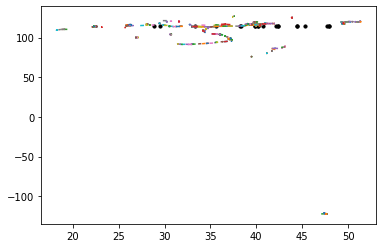

In [113]:
for i in range(len(data)):
    plt.plot(data[i][0][:,0], data[i][0][:,1]);

plt.scatter(Q[:,0], Q[:,1], s = 10, color = "black")
plt.show()

### Experience with feature mapping $\phi_3 = v_Q$

In [47]:
Data = featureMapping3(data, Q)
train, test = trainTestSplit(Data)
X = localModel(train)

#### Linear SVM

In [55]:
clf = trainLinearSVM(X, C_list = [1e8]*5)
print("train accuracy =", predictViterbiSVM(train, clf)[1])
print("test accuracy =", predictViterbiSVM(test, clf)[1])

train accuracies for local classifiers given x_i and y_{i-1} =
[0.48832036 0.35773481 0.37987589 0.41860465 0.38673139]
train accuracy = 0.4276140155728587
test accuracy = 0.4290553080920564


#### Gaussian SVM

In [56]:
clf = trainGauSVM(X, C_list = [1e4]*5, kernel_list = ['rbf']*5, gamma_list = [1]*5)
print("train accuracy =", predictViterbiSVM(train, clf)[1])
print("test accuracy =", predictViterbiSVM(test, clf)[1])

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

train accuracies for local classifiers given x_i and y_{i-1} =
[0.70828699 0.63639503 0.68572695 0.71627907 0.72330097]
train accuracy = 0.5466629588431591
test accuracy = 0.48827951002227177


#### Decision Tree

In [53]:
clfTree = trainDT(X)
print("train accuracy =", predictViterbiDT_RF(train, clfTree)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfTree)[1])

train accuracies for local classifiers given x_i and y_{i-1} =
[1. 1. 1. 1. 1.]
train accuracy = 1.0
test accuracy = 0.6825909428359317


#### Random Forest

In [57]:
clfRF = trainRF(X, 20)
print("train accuracy =", predictViterbiDT_RF(train, clfRF)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfRF)[1])

train accuracies for local classifiers given x_i and y_{i-1} =
[0.99388209 0.99551105 0.99734043 0.99476744 0.99190939]
train accuracy = 0.9949295513533555
test accuracy = 0.7244988864142538


In [59]:
clfRF = trainRF(X, 100)
print("train accuracy =", predictViterbiDT_RF(train, clfRF)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfRF)[1])

train accuracies for local classifiers given x_i and y_{i-1} =
[1.         1.         0.99955674 1.         1.        ]
train accuracy = 1.0
test accuracy = 0.729370824053452


### Experience with feature mapping $\phi_4 = v_Q$ + $\phi_1$

In [114]:
Data = featureMapping4(data, Q)
train, test = trainTestSplit(Data)
X = localModel(train)

#### Linear SVM

In [115]:
clf = trainLinearSVM(X, C_list = [1]*5)
print("train accuracy =", predictViterbiSVM(train, clf)[1])
print("test accuracy =", predictViterbiSVM(test, clf)[1])

train accuracies for local classifiers given x_i and y_{i-1} =
[0.58866037 0.52555249 0.54162976 0.53667055 0.52845528]
train accuracy = 0.5218732629238465
test accuracy = 0.5281644394951744


#### Gaussian SVM

In [117]:
clf = trainGauSVM(X, C_list = [1e4]*5, kernel_list = ['rbf']*5, gamma_list = [1]*5)
print("train accuracy =", predictViterbiSVM(train, clf)[1])
print("test accuracy =", predictViterbiSVM(test, clf)[1])

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

train accuracies for local classifiers given x_i and y_{i-1} =
[0.8627015  0.89779006 0.93312666 0.94703143 0.96178862]
train accuracy = 0.7336714841578654
test accuracy = 0.5287397921306607


#### Decision Tree

In [118]:
clfTree = trainDT(X)
print("train accuracy =", predictViterbiDT_RF(train, clfTree)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfTree)[1])

train accuracies for local classifiers given x_i and y_{i-1} =
[1. 1. 1. 1. 1.]
train accuracy = 1.0
test accuracy = 0.7343541202672607


#### Random Forest

In [119]:
clfRF = trainRF(X, 20)
print("train accuracy =", predictViterbiDT_RF(train, clfRF)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfRF)[1])

train accuracies for local classifiers given x_i and y_{i-1} =
[0.99638688 0.99585635 0.99734278 0.99708964 0.99756098]
train accuracy = 0.9960857884009634
test accuracy = 0.8237286562731996


In [120]:
clfRF = trainRF(X, 100)
print("train accuracy =", predictViterbiDT_RF(train, clfRF)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfRF)[1])

train accuracies for local classifiers given x_i and y_{i-1} =
[1.         1.         1.         0.99941793 1.        ]
train accuracy = 0.9999444135630906
test accuracy = 0.8316536748329622


### Experience with feature mapping $\phi_5 = v_Q$ + $\phi_2$

In [121]:
Data = featureMapping5(data, Q)
train, test = trainTestSplit(Data)
X = localModel(train)

#### Linear SVM

In [123]:
clf = trainLinearSVM(X, C_list = [1]*5)
print("train accuracy =", predictViterbiSVM(train, clf)[1])
print("test accuracy =", predictViterbiSVM(test, clf)[1])

train accuracies for local classifiers given x_i and y_{i-1} =
[0.59505281 0.5176105  0.54517272 0.55529686 0.55365854]
train accuracy = 0.5279043913285159
test accuracy = 0.514355976243504


#### Gaussian SVM

In [125]:
clf = trainGauSVM(X, C_list = [1e4]*5, kernel_list = ['rbf']*5, gamma_list = [1]*5)
print("train accuracy =", predictViterbiSVM(train, clf)[1])
print("test accuracy =", predictViterbiSVM(test, clf)[1])

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


train accuracies for local classifiers given x_i and y_{i-1} =
[0.88966092 0.92921271 0.94641275 0.97380675 0.97235772]
train accuracy = 0.7554243098017417
test accuracy = 0.525231997030438


#### Decision Tree

In [126]:
clfTree = trainDT(X)
print("train accuracy =", predictViterbiDT_RF(train, clfTree)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfTree)[1])

train accuracies for local classifiers given x_i and y_{i-1} =
[1. 1. 1. 1. 1.]
train accuracy = 1.0
test accuracy = 0.7451837416481069


#### Random Forest

In [127]:
clfRF = trainRF(X, 20)
print("train accuracy =", predictViterbiDT_RF(train, clfRF)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfRF)[1])

train accuracies for local classifiers given x_i and y_{i-1} =
[0.99749861 0.99551105 0.99689991 0.99534342 0.99756098]
train accuracy = 0.9963915138039651
test accuracy = 0.8228841870824054


In [128]:
clfRF = trainRF(X, 100)
print("train accuracy =", predictViterbiDT_RF(train, clfRF)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfRF)[1])

train accuracies for local classifiers given x_i and y_{i-1} =
[1. 1. 1. 1. 1.]
train accuracy = 1.0
test accuracy = 0.8276818856718634
